# Testing-based Learner

Causal discovery attracts more and more attention recently to infer causal structure from data and disentangles the complex relationship among variables. In the following, we detail a state-of-the-art causal discovery learner, PC Algorithm (Spirtes et al., 2000; Kalisch & Bühlmann, 2007), named by the first two authors, Pater and Clark, as a testing-based learner.

***Application situations***: 
    
1. The noises are normally distributed. 
2. The causal relationship among nodes are linear.

***Advantage of the learner***:

1. Provide the p-value of local conditional independence tests to find a causal graph;
2. Easy to establish statistical inference on the estimated graph;
3. Results are invariant to data trasformation. 
    
***Disadvantage of the learner***:

1. Require noises with equal variances for the identification of a unique graph;
2. Cannot handle high-dimensional nodes unless strong sparsity is reasonable;
3. Cannot handle non-linear cases due to hardness of conditional teatings. 

## Main Idea:

### 1. Causal Graph Terminology and Goal

Consider a graph $\mathcal{G} =(\mathbf{Z},\mathbf{E})$ with a node set $\mathbf{Z}$ and an edge set $\mathbf{E}$. A node $Z_i$ is said to be a parent of $Z_j$ if there is a directed edge from $Z_i$ to $Z_j$. Let the set of all parents of node $Z_j$ in $\mathcal{G}$ as $PA_{Z_j} (\mathcal{G})$. A directed graph that does not contain directed cycles is called a directed acyclic graph (DAG). Suppose a DAG $\mathcal{G}=(\mathbf{Z},\mathbf{E})$ that characterizes the causal relationship among $|\mathbf{Z}|=d$ nodes, where $\mathbf{Z}=[Z_1,Z_2,\cdots,Z_d]^\top $ represents a random vector and an edge $Z_i\rightarrow Z_j$ means that $Z_i$ is a direct cause of $Z_j$.  Given realizations of the variable set $\mathbf{Z}$ as $\{z_1^{(i)},z_2^{(i)},\cdots,z_d^{(i)}\}_{1\leq i \leq n}$, we aim to estimate the underlying causal graph $\mathcal{G}$.

### 2. Applicable Causal Graphical Models 

#### Model 1: Linear-Gaussian Structural Equation Model

Let $B=\{b_{i,j}\}_{1\leq i\leq d,1\leq j\leq d}$ be a $d\times d$ matrix, where $b_{i,j}$ is the weight of the edge $Z_i\rightarrow Z_j \in \mathbf{E}$, and $b_{i,j}=0$ otherwise. Then, we say that $\mathcal{G} =(\mathbf{Z},B)$ is a weighted DAG with the node set $\mathbf{Z}$ and the weighted adjacency matrix $B$ (the edge set $\mathbf{E}$ is nested in $B$). Under no unmeasured confounders, the Markov condition, the faithfulness condition, causal sufficiency assumption, and the linear structural equation model (LSEM) such that $\mathbf{Z}$ characterized by the pair ($\mathcal{G}$, $\epsilon$) is generated by 
\begin{equation}\label{lsem_x}
\mathbf{Z}=B^\top \mathbf{Z} +\epsilon,
\end{equation}
where $\epsilon $ is a  random vector of jointly independent error variables. When the noise is Gaussian with equal variance, the model is identifiable (Peters and Bühlmann, 2013).  


### 3. Algorithm Details

The classical PC algorithm (Spirtes et al., 2000) proposes to leverage the Fisher-z test for conditional independence testing, in order to determine the orientation/direction of the edge between each pair of the nodes. The implementation is available through the py-causal package at https://github.com/bd2kccd/py-causal, written in highly optimized Java codes. Also see examples here https://github.com/bd2kccd/py-causal/blob/development/example/py-causal%20-%20PC-ALL%20in%20Action.ipynb.
 

## Demo Code

### Generate Synthetic Datasets

In [1]:
import os
import numpy as np
from utils import *
from synthetic_datasets import *
seed = 1234
np.random.seed(seed)
d = 8
n = 300
ground_truth_G = simulate_random_dag(d=d, degree=2, graph_type='erdos-renyi', w_range = (1.0, 1.0))
c = np.zeros(d)
s = np.ones([d])
df = simulate_lsem(G = ground_truth_G, A_type ='Gaussian', n = n, baseline=0).reshape((n,d))

#plot true causal graph:
plot_net(nx.to_numpy_array(ground_truth_G), labels_name=list(range(d))) 

ModuleNotFoundError: No module named 'synthetic_datasets'

### Causal Discovery by PC Algorithm

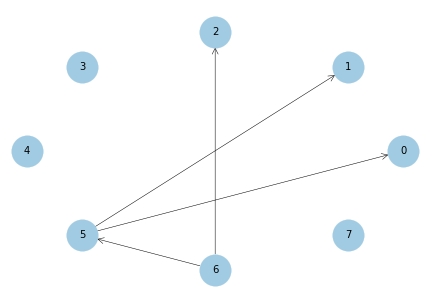

FDR: 0.0
TPR: 0.5
SHD: 4


In [2]:
# ! pip install pydot 
# ! pip install git+https://github.com/bd2kccd/py-causal
from utils import *
import pydot
from pycausal.pycausal import pycausal as pc
from pycausal import search as s
pc = pc()
pc.start_vm() 
tetrad = s.tetradrunner() 
new_df = pd.DataFrame(data=df, index=range(len(df)), columns=map('{:02}'.format, range(d)))
tetrad.run(algoId = 'pc-all', dfs = new_df, testId = 'fisher-z-test')
graph = tetrad.getTetradGraph()
nodes = graph.getNodes()
dot_str = pc.tetradGraphToDot(graph)
graphs = pydot.graph_from_dot_data(dot_str)
for node in map('{:02}'.format, range(d)):
    node_a = pydot.Node(node, style="filled", fillcolor="red")
    graphs[0].add_node(node_a)
graph = nx.to_numpy_array(nx.nx_pydot.from_pydot(graphs[0]))
pc_res = np.matrix(graph)
pc_res[np.abs(pc_res) < 0.3] = 0 
#plot the estimated causal graph:
plot_net(pc_res, labels_name=list(range(d))) 

FDR, TPR, SHD = count_accuracy(nx.DiGraph(ground_truth_G), nx.DiGraph(pc_res))
print('FDR:', np.round(FDR, 2)) 
print('TPR:', np.round(TPR, 2)) 
print('SHD:', np.round(SHD, 2)) 

#### Summary of Results under Different Causal Graph Learners.

Note: The estimated graphs (after pruning) are evaluated by three metrics: the false discovery rate (FDR), the true positive rate (TPR), and the structural Hamming distance (SHD, the smallest number of edge additions, deletions, and reversals to convert the estimated graph into the true DAG). Here, the SHD takes into account both false positives and negatives and a lower SHD indicates a better estimate of the causal graph.

| Learners |   FDR   |   TPR   |   SHD   |
|----------|---------|---------|---------|
|    PC    |   0.00  |   0.50  |   4     |
|ICA-LiNGAM|   0.67  |   0.25  |   7     |
| NOTEARS  |   0.00  |   0.62  |   3     |
|  DAGGNN  |   0.00  |   0.62  |   3     |

## References

[1] Judea Pearl et al. Causal inference in statistics: An overview. Statistics surveys, 3:96–146, 2009.

[2] Pater Spirtes, Clark Glymour, Richard Scheines, Stuart Kauffman, Valerio Aimale, and Frank Wimberly. Constructing bayesian network models of gene expression networks from microarray data. 2000.

[3] Markus Kalisch and Peter Bühlmann. Estimating high-dimensional directed acyclic graphs with the pc-algorithm. Journal of Machine Learning Research, 8(Mar):613–636, 2007.

[4] Rajen D Shah and Jonas Peters. The hardness of conditional independence testing and the generalised covariance measure. arXiv preprint arXiv:1804.07203, 2018.

[5] Shohei Shimizu, Patrik O Hoyer, Aapo Hyvärinen, and Antti Kerminen. A linear non-gaussian acyclic model for causal discovery. Journal of Machine Learning Research, 7(Oct):2003–2030, 2006.

[6] Peter Bühlmann, Jonas Peters, Jan Ernest, et al. Cam: Causal additive models, high-dimensional order search and penalized regression. The Annals of Statistics, 42(6):2526–2556, 2014.

[7] David Maxwell Chickering. Optimal structure identification with greedy search. Journal of machine learning research, 3(Nov):507–554, 2002.

[8] Joseph Ramsey, Madelyn Glymour, Ruben Sanchez-Romero, and Clark Glymour. A million variables and more: the fast greedy equivalence search algorithm for learning high-dimensional graphical causal models, with an application to functional magnetic resonance images. International journal of data science and analytics, 3(2):121–129, 2017.

[9] Xun Zheng, Bryon Aragam, Pradeep K Ravikumar, and Eric P Xing. Dags with no tears: Continuous optimization for structure learning. In Advances in Neural Information Processing Systems, pp. 9472–9483, 2018.

[10] Yue Yu, Jie Chen, Tian Gao, and Mo Yu. Dag-gnn: Dag structure learning with graph neural networks.
arXiv preprint arXiv:1904.10098, 2019.

[11] Shengyu Zhu and Zhitang Chen. Causal discovery with reinforcement learning. arXiv preprint arXiv:1906.04477, 2019.

[12] Cai, Hengrui, Rui Song, and Wenbin Lu. "ANOCE: Analysis of Causal Effects with Multiple Mediators via Constrained Structural Learning." International Conference on Learning Representations. 2020.

[13] J. Peters and P. Bühlmann. Identifiability of Gaussian structural equation models with equal error variances.
Biometrika, 101(1):219–228, 2013.

[14] J. Peters, J. Mooij, D. Janzing, and B. Schölkopf. Causal Discovery with Continuous Additive Noise Models.
Journal of Machine Learning Research, 2014.